In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from Main_functions import *
from numpy.random import zipf
import random
from numpy import genfromtxt

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalue of ground truth $M_t$, we randomly generate it.

In [2]:
d = 10
rank = 5
seed = 2023

In [3]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [4]:
# eigenvalues of $M_t$
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [5]:
data_model = DG(diag, seed = 22) 

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [6]:
data_model.M_diag, 

(array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ]),)

In [7]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

In [8]:
# data_model.U

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [9]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)
diag_cov

array([0.59, 0.7 , 0.19, 0.04, 0.21, 0.11, 0.73, 0.68, 0.47, 0.45])

In [10]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [11]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

In [12]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


### Check the average empirically

In [13]:
N = 5000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 1.7197533768399575


### Set $\tau$ to generate data points (binary case!)

In [14]:
tau = [1.3]
N = 20000
noise = 0.208

In [15]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = 'Noisy_labeling', noise_par = noise)

In [16]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.1029


In [17]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i,(D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 10201
number of pairs with 1 as their labels is 9799


In [18]:
(D_noisy == 0).sum()/N

0.50595

### change to PyTorch tensor!

In [19]:
X = torch.tensor(X, dtype = torch.float64)
Y = torch.tensor(Y, dtype = torch.float64)
D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [20]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                 Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 15000)

In [21]:
X.dtype, D.dtype

(torch.float64, torch.int64)

## Set the model and train it

In [22]:
k = 10
n_labels = len(tau)+1

In [23]:
model = ML(d, k, n_labels, 
   X_T, Y_T, D_T, D_no_noise_T, 
   X_test, Y_test, D_test, D_no_noise_test)

In [24]:
model.train(learning_rate = 5e-1, 
            n_iters = 30001, 
            decay = .95,
            f = f, 
            B_star = data_model.B_t, 
            tau_star = data_model.tau_t, 
            N = 1000)

Starting Tau:  tensor([0.9698], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.7999717179547341
train accuracy with noise 0.5066
train accuracy without noise 0.5096666666666667
test accuracy with noise 0.504
test accuracy without noise 0.5112
epoch 5000:
 norm of B.grad = 1.838811566713398e-10,
 loss = 0.4563198817113805
tensor([2.8747], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8558
train accuracy without noise 0.9468666666666666
test accuracy with noise 0.8492
test accuracy without noise 0.9412
epoch 10000:
 norm of B.grad = 3.217120636088546e-16,
 loss = 0.4563198485981512
tensor([2.8749], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8557333333333333
train accuracy without noise 0.9468
test accuracy with noise 0.8492
test accuracy without noise 0.9412
epoch 15000:
 norm of B.grad = 1.2400711777036183e-21,
 loss = 0.45631984859809344
tensor([2.8749], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.855

In [25]:
N = 10000
X_new, Y_new, _, D_new = data_model.generate(f, N, tau = np.array(tau), 
                               noise_type = None, noise_par = None)

In [26]:
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [27]:
ac_unseen = model.accuracy(X_new, Y_new, D_new)
print('accuracy on unseen data {}'.format(ac_unseen))

accuracy on unseen data 0.9457


### Relative errors

$$\frac{\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_2}{\left\|\frac{M^*}{\tau^*}\right\|_2}$$

In [28]:
M_hat_normal = model.B @ model.B.T / model.Tau[0] 

In [29]:
M_t_normal = data_model.M_t/tau[0]

In [30]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.20736804889292856

$$\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_\infty$$

In [31]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.04857210153103603

$$\left|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right|_{L_1(f)}$$

In [32]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.1800561145142473

$$\left|\hat{\tau} - \frac{\tau^*}{s}\right|$$

In [33]:
# np.abs(model.Tau.detach().numpy()[0] - data_model.tau_t[0]/s)

$$\frac{\left|\hat{\tau} - \frac{\tau^*}{s}\right|}{\frac{\tau^*}{s}}$$

In [34]:
# np.abs(model.Tau.detach().numpy()[0] - data_model.tau_t[0]/s)/ (data_model.tau_t[0]/s)

In [35]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).mean()

0.012987124303062321

In [36]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.04857210153103603

In [37]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.20736804889292856

In [38]:
np.sqrt((M_t_normal**2).sum())

0.8699792556868479

In [39]:
print(model.Tau.detach().numpy())
print(np.array(tau))
print(model.Tau.detach().numpy()[0]/np.array(tau)[0])

[2.87487491]
[1.3]
2.2114422373481095


In [40]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.17879308737628827

In [2]:
s_prime = np.array(tau)[0]/model.Tau.detach().numpy()[0]
print(s_prime)

NameError: name 'np' is not defined

In [42]:
print(loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s_prime), data_model.tau_t/s_prime).item())
print(loss(X_T - Y_T, D_T, model.B, model.Tau).item())
print(model.loss_history[-1].item())

0.4717615780351006
0.45631984859809355
0.4563198485980935


In [43]:
print(loss(X_T - Y_T, D_T, data_model.B_t/data_model.tau_t[0], np.zeros(1)).item())
print(loss(X_T - Y_T, D_T, model.B/model.Tau[0], np.zeros(1)).item())

0.6435669048378596
0.6394614976265417


In [44]:
Pred_test = pred(X_test, Y_test, data_model.B_t, np.array(tau))
print("test accuracy with noise (Using ground truth) = ", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise (Using ground truth) = ", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise (Using ground truth) =  0.898
test accuracy without noise (Using ground truth) =  1.0


In [45]:
Pred_test = pred(X_test, Y_test, model.B, model.Tau)
print("test accuracy with noise", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise 0.8492
test accuracy without noise 0.9412


In [46]:
U_hat, S_hat, V_hat = LA.svd(M_hat_normal.detach().numpy(), full_matrices=False)

In [47]:
U_t, S_t, V_t = LA.svd(M_t_normal, full_matrices=False)

In [48]:
S_hat.sum(), S_t.sum()

(1.4423064120095144, 1.5923076923076906)

In [49]:
S_hat

array([5.48242975e-01, 4.41496080e-01, 2.37639476e-01, 1.02630534e-01,
       9.29223005e-02, 1.93750466e-02, 9.67568355e-16, 4.31297207e-17,
       1.67336947e-17, 5.74515291e-18])

In [50]:
S_t

array([6.84615385e-01, 4.53846154e-01, 2.46153846e-01, 1.07692308e-01,
       1.00000000e-01, 4.36695175e-17, 2.06400798e-17, 1.41402615e-17,
       1.24080830e-17, 2.09411824e-18])

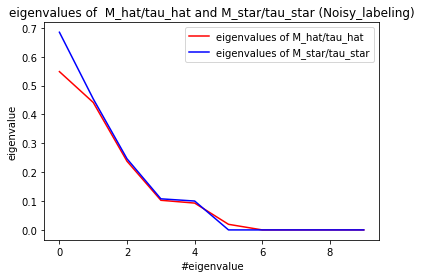

In [51]:
plt.plot(S_hat, label = 'eigenvalues of M_hat/tau_hat', color= 'red')
plt.plot(S_t, label = 'eigenvalues of M_star/tau_star', color = 'blue')
plt.legend()
plt.xlabel('#eigenvalue', fontsize=10)
plt.ylabel('eigenvalue', fontsize=10)
plt.title('eigenvalues of  M_hat/tau_hat and M_star/tau_star (Noisy_labeling)', fontsize= 12)
plt.savefig("Images/Noisy_labeling/eigenNoisy_labeling")
plt.show()

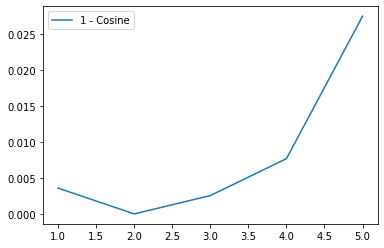

In [52]:
H = []
m = 5
for i in range(m):
    H.append(proj(U_hat[:, i], U_t[:, :m]))
    
plt.plot([j+1 for j in range(m)], H, label = '1 - Cosine')
plt.legend()
plt.savefig("Images/Noisy_labeling/Cosine")
plt.show()

In [53]:
np.savetxt("CSVs/Noisy_labeling/Cosine.csv", 
           H,
           delimiter =", ", 
           fmt ='% s')

In [54]:
for i in range(d):
    print(np.dot(U_hat[:,i], U_t[:,i]))

0.973279221457072
0.9818600283972175
0.9862987342781209
0.9726098732050529
0.9579533704825323
-0.03467831029353652
-0.5183661122082401
0.24674735543917986
0.016789469143352227
0.28489352164722315


In [55]:
np.diag(U_hat.T @ U_t)

array([ 0.97327922,  0.98186003,  0.98629873,  0.97260987,  0.95795337,
       -0.03467831, -0.51836611,  0.24674736,  0.01678947,  0.28489352])

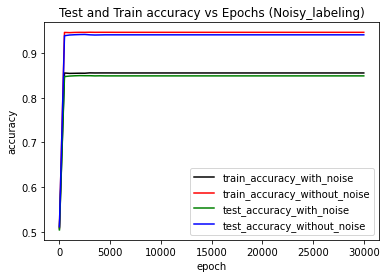

In [56]:
I = model.epoch_history
plt.plot(I, model.train_accuracy_with_noise, label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I, model.train_accuracy_without_noise, label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, model.test_accuracy_with_noise, label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, model.test_accuracy_without_noise, label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()

plt.xlabel('epoch', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('Test and Train accuracy vs Epochs (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/Test_and_Train_accuracy_vs_epochs")
plt.show()

In [57]:
np.savetxt("CSVs/Noisy_labeling/model_epoch_history.csv", 
           model.epoch_history,
           delimiter =", ", 
           fmt ='% s')

In [58]:
np.savetxt("CSVs/Noisy_labeling/model_train_accuracy_with_noise.csv", 
           model.train_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [59]:
np.savetxt("CSVs/Noisy_labeling/model_train_accuracy_without_noise.csv", 
           model.train_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [60]:
np.savetxt("CSVs/Noisy_labeling/model_test_accuracy_with_noise.csv", 
           model.test_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [61]:
np.savetxt("CSVs/Noisy_labeling/model_test_accuracy_without_noise.csv", 
           model.test_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [62]:
model.loss_history[-1].item()

0.4563198485980935

In [63]:
# loss(X_T - Y_T, D_T, model.B, model.Tau).item()
l_value = loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s_prime), data_model.tau_t/s_prime).item()
I_ = np.array([l_value for _ in I])

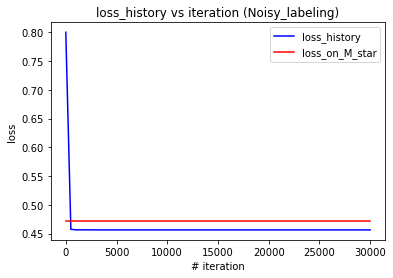

In [64]:
plt.plot(I[:], model.loss_history[:], label = 'loss_history', color = 'blue')
plt.plot(I[:], I_[:], label = 'loss_on_M_star', color = 'red')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('loss', fontsize=10)
plt.title('loss_history vs iteration (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/loss_history_vs_iteration")
plt.show()

In [65]:
np.savetxt("CSVs/Noisy_labeling/model.loss_history.csv", 
           model.loss_history,
           delimiter =", ", 
           fmt ='% s')

In [66]:
np.savetxt("CSVs/Noisy_labeling/true_loss_history.csv", 
           I_,
           delimiter =", ", 
           fmt ='% s')

In [67]:
model.L_1_f_norm_history[-1]

0.17608872433132183

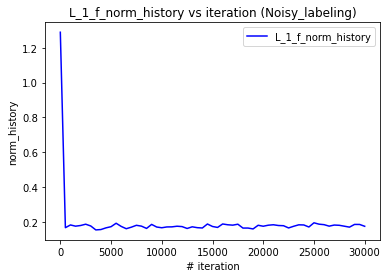

In [68]:
plt.plot(I[:], model.L_1_f_norm_history[:], label = 'L_1_f_norm_history', color = 'blue')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('norm_history', fontsize=10)
plt.title('L_1_f_norm_history vs iteration (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/norm_history_vs_iteration")
plt.show()

In [69]:
np.savetxt("CSVs/Noisy_labeling/model_L_1_f_norm_history.csv", 
           model.L_1_f_norm_history,
           delimiter =", ", 
           fmt ='% s')

### Sample Complexity

In [70]:
noise = 0.2
d = 10
k = 10
n_labels = len(tau)+1

In [71]:
H = []
J = []
N = 0
while N <= 10000:
    if N < 100:
        N += 10
    elif N < 1000:
        N += 100
    elif N < 5000:
        N+= 1000
    else: N += 5000
    
    
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
                                                    N + 2000, 
                                                    tau = np.array(tau), 
                                                    noise_type = 'Noisy_labeling', 
                                                    noise_par = noise)
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
        
    print('round for N = {} has started'.format(N))
    
    J.append(N)
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                     Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = N)
    model = ML(d, k, n_labels, 
               X_T, Y_T, 
               D_T, D_no_noise_T, 
               X_test, Y_test, 
               D_test, D_no_noise_test) 
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30000, 
                decay = .95, 
                show_log = False)
    H.append(model)

round for N = 10 has started
round for N = 20 has started
round for N = 30 has started
round for N = 40 has started
round for N = 50 has started
round for N = 60 has started
round for N = 70 has started
round for N = 80 has started
round for N = 90 has started
round for N = 100 has started
round for N = 200 has started
round for N = 300 has started
round for N = 400 has started
round for N = 500 has started
round for N = 600 has started
round for N = 700 has started
round for N = 800 has started
round for N = 900 has started
round for N = 1000 has started
round for N = 2000 has started
round for N = 3000 has started
round for N = 4000 has started
round for N = 5000 has started
round for N = 10000 has started
round for N = 15000 has started


In [72]:
H[-1].accuracy(X_new, Y_new, D_new)

0.9529

In [73]:
test_accuracy_no_noise  = [H[i].accuracy(X_new, Y_new, D_new) for i in range(len(H))]

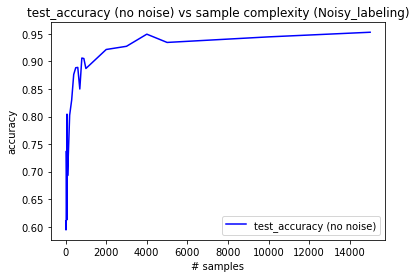

In [74]:
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (no noise) vs sample complexity (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/test_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [75]:
np.savetxt("CSVs/Noisy_labeling/test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [76]:
np.savetxt("CSVs/Noisy_labeling/number_samples_list.csv", 
           J,
           delimiter =", ", 
           fmt ='% s')

In [77]:
test_accuracy_noisy  = [H[i].accuracy(H[i].X_test, H[i].Y_test, H[i].D_test) for i in range(len(H))]

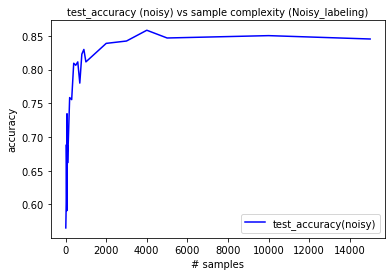

In [78]:
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (noisy) vs sample complexity (Noisy_labeling)', fontsize=10)
plt.savefig("Images/Noisy_labeling/test_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [79]:
np.savetxt("CSVs/Noisy_labeling/test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [80]:
train_accuracy_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_T) for i in range(len(H))]

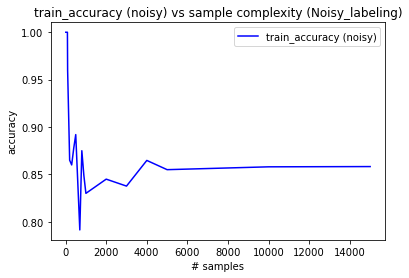

In [81]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (noisy) vs sample complexity (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/train_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [82]:
np.savetxt("CSVs/Noisy_labeling/train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [83]:
train_accuracy_no_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_no_noise_T) for i in range(len(H))]

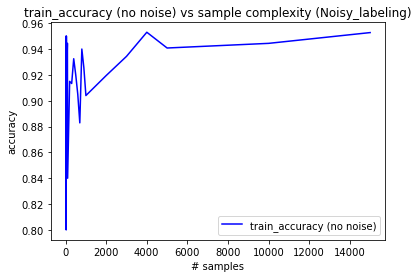

In [84]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/train_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [85]:
np.savetxt("CSVs/Noisy_labeling/train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

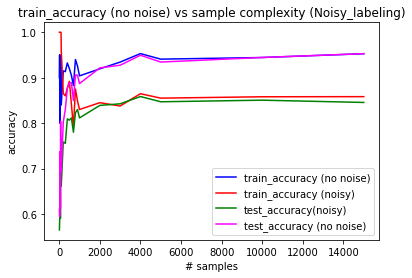

In [86]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'red')
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'green')
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'magenta')

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity (Noisy_labeling)', fontsize=12)
plt.savefig("Images/Noisy_labeling/accuracy_vs_sample_complexity")
plt.show()

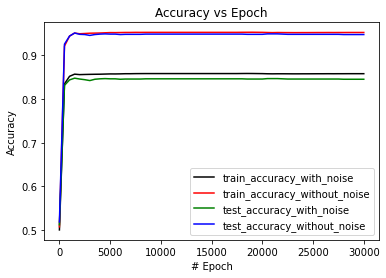

In [87]:
I = H[-1].epoch_history[:]
plt.plot(I, H[-1].train_accuracy_with_noise[:], label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I, H[-1].train_accuracy_without_noise[:], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, H[-1].test_accuracy_with_noise[:], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, H[-1].test_accuracy_without_noise[:], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()
plt.xlabel('# Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs Epoch', fontsize=12)
plt.savefig('Images/Noisy_labeling/Accuracy_vs_Epoch')
plt.show()

### How much noise breaks the model!

In [88]:
print(tau)
N = 20000

[1.3]


In [89]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = 'Noisy_labeling', noise_par = 0.6)
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.2938


In [90]:
(D_no_noisy == 0).sum(), (D_no_noisy == 1).sum(), (D_no_noisy == 1).sum()/N

(10050, 9950, 0.4975)

In [91]:
noise_list = 2 * genfromtxt('CSVs/logistic/noise_list_history.csv', delimiter = ',')

In [92]:
noise_list

array([0.        , 0.09857143, 0.19985714, 0.29235714, 0.36664286,
       0.43607143, 0.48335714, 0.54057143, 0.57214286, 0.60142857,
       0.63114286, 0.68142857, 0.70957143, 0.74157143, 0.7675    ,
       0.78614286, 0.80714286, 0.90271429, 0.992     ])

In [93]:
N=28000
d = 10
k = 10
n_labels = len(tau) + 1
noise_list_history = []
model_history = []
for noise in noise_list:
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                                    noise_type = 'Noisy_labeling', noise_par = noise)
    noise_amount = (D_noisy != D_no_noisy).mean()
    print('the amount of noise: {}'.format(noise_amount))
    noise_list_history.append(noise_amount)
    
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
    
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X,
                                                                                                     Y, 
                                                                                                     D_noisy, 
                                                                                                     D_no_noisy, 
                                                                                                    n_train = 18000)
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T,
               X_test, Y_test, D_test, D_no_noise_test)
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30001, 
                decay = .95, 
                show_log = False)
    
    model_history.append(model)
    
    print('train_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                           model_history[-1].Y_T, 
                                                                           model_history[-1].D_T)))
    
    print('test_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                          model_history[-1].Y_test, 
                                                                          model_history[-1].D_test)))
    
    print('train_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                             model_history[-1].Y_T, 
                                                                             model_history[-1].D_no_noise_T)))
    
    print('test_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                            model_history[-1].Y_test, 
                                                                            model_history[-1].D_no_noise_test)))
    print('\n')

the amount of noise: 0.0
train_accuracy (noisey) = 0.9971666666666666
test_accuracy (noisey) = 0.994
train_accuracy (no noise) = 0.9971666666666666
test_accuracy (no noise) = 0.994


the amount of noise: 0.04864285714285714
train_accuracy (noisey) = 0.9216111111111112
test_accuracy (noisey) = 0.9229
train_accuracy (no noise) = 0.9682777777777778
test_accuracy (no noise) = 0.9683


the amount of noise: 0.09896428571428571
train_accuracy (noisey) = 0.8608888888888889
test_accuracy (noisey) = 0.8593
train_accuracy (no noise) = 0.9502777777777778
test_accuracy (no noise) = 0.9523


the amount of noise: 0.14539285714285713
train_accuracy (noisey) = 0.8078888888888889
test_accuracy (noisey) = 0.8075
train_accuracy (no noise) = 0.9315555555555556
test_accuracy (no noise) = 0.9332


the amount of noise: 0.17735714285714285
train_accuracy (noisey) = 0.7728333333333334
test_accuracy (noisey) = 0.7751
train_accuracy (no noise) = 0.9207222222222222
test_accuracy (no noise) = 0.9225


the amount of

In [94]:
np.savetxt("CSVs/Noisy_labeling/noise_list_history.csv", 
           noise_list_history,
           delimiter =", ", 
           fmt ='% s')

In [95]:
# plt.plot(noise_par_list, noise_list_history, label = 'variance VS noise', color = 'blue')
# plt.legend()
# plt.ylabel('# Noise', fontsize = 10)
# plt.xlabel('variance', fontsize = 10)
# # plt.title('unseen_accuracy (no noise) vs sample complexity', fontsize = 10)
# plt.show()

In [96]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

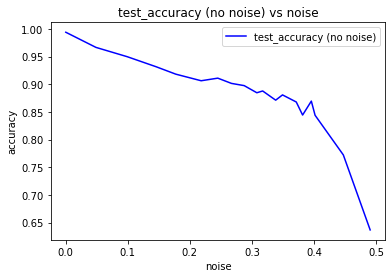

In [97]:
test_accuracy_no_noise  = [model_history[i].accuracy(X_new, 
                                                     Y_new, 
                                                     D_new) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test_accuracy (no noise) vs noise', fontsize = 12)
plt.savefig('Images/Noisy_labeling/Test_accuracy_(no_noise)_vs_noise')
plt.show()

In [98]:
np.savetxt("CSVs/Noisy_labeling/test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [99]:
[(noise_list_history[i], test_accuracy_no_noise[i]) for i in range(len(noise_list_history))]

[(0.0, 0.9941),
 (0.04864285714285714, 0.9667),
 (0.09896428571428571, 0.9499),
 (0.14539285714285713, 0.9318),
 (0.17735714285714285, 0.9183),
 (0.21817857142857142, 0.9064),
 (0.245, 0.9111),
 (0.26707142857142857, 0.9016),
 (0.2875357142857143, 0.8976),
 (0.3079642857142857, 0.8847),
 (0.31735714285714284, 0.8879),
 (0.33832142857142855, 0.8713),
 (0.34932142857142856, 0.8808),
 (0.3715, 0.868),
 (0.38171428571428573, 0.8444),
 (0.3957857142857143, 0.8696),
 (0.40182142857142855, 0.844),
 (0.44735714285714284, 0.7723),
 (0.49060714285714285, 0.6367)]

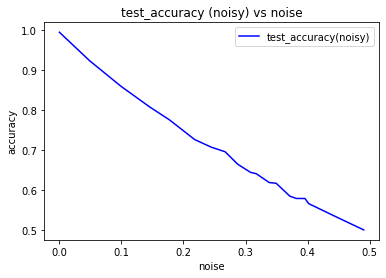

In [100]:
test_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_test, 
                                                  model_history[i].Y_test, 
                                                  model_history[i].D_test) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test_accuracy (noisy) vs noise', fontsize = 12)
plt.savefig('Images/Noisy_labeling/test_accuracy_(noisy)_vs_noise')
plt.show()

In [101]:
np.savetxt("CSVs/Noisy_labeling/test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

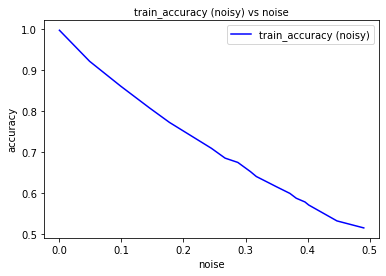

In [102]:
train_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                   model_history[i].Y_T, 
                                                   model_history[i].D_T) for i in range(len(model_history))]

plt.plot(noise_list_history, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (noisy) vs noise', fontsize = 10)
plt.savefig('Images/Noisy_labeling/train_accuracy_(noisy)_vs_noise')
plt.show()

In [103]:
np.savetxt("CSVs/Noisy_labeling/train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [104]:
train_accuracy_no_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                      model_history[i].Y_T, 
                                                      model_history[i].D_no_noise_T) for i in range(len(model_history))]

In [105]:
np.savetxt("CSVs/Noisy_labeling/train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

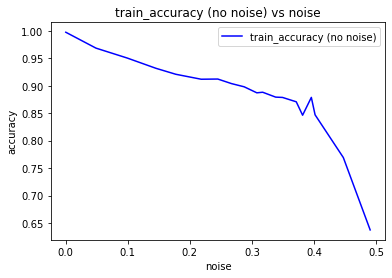

In [106]:
plt.plot(noise_list_history, 
         train_accuracy_no_noisy, 
         label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (no noise) vs noise', fontsize = 12)
plt.savefig('Images/Noisy_labeling/train_accuracy_(no_noise)_vs_noise')
plt.show()

In [107]:
noise_list_history[-1], train_accuracy_no_noisy[-1]

(0.49060714285714285, 0.6376666666666667)